In [22]:
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import pickle
import sklearn
import pandas as pd
import pandas as pd

import pandas as pd

import typing
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Lasso, Ridge
from sklearn.impute import SimpleImputer

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, root_mean_squared_error, r2_score, mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
import pandas as pd
import country_converter as coco

random_state = 123

##  Preprocessing:


In [23]:
import pandas as pd
import country_converter as coco


df = pd.read_csv("df_extended.csv", index_col=0)
df.shape

df['International Students'] = (
    df['International Students']
    .str.rstrip('%')
    .replace('', '0')
    .replace('N/A', 'N/A')
)

def convert_ratio(value):
    try:
        if ':' in value:
            parts = value.split(':')
            num1, num2 = float(parts[0]), float(parts[1])
            return num1 / num2
        else:
            return float(value)
    except:
        return None

df['Female to Male Ratio'] = df['Female to Male Ratio'].apply(convert_ratio)

country_to_continent = {}
def get_continent(country):
    if country not in country_to_continent:
        country_to_continent[country] = coco.CountryConverter().convert(names=country, to='continent')
    return country_to_continent[country]

df['Country'] = df['Country'].astype(str)

df['Continent'] = df['Country'].apply(get_continent)

df.to_csv("universities.csv", index=False)


## Question 1: How do university rankings change over time? Which country stands out? Which university stands out? Which fields dominate in each year? Ranking by continents? Ranking by field? Did COVID affect the rankings?


## How do univsersity rankings change over time?


In [24]:
df = pd.read_csv("universities.csv")


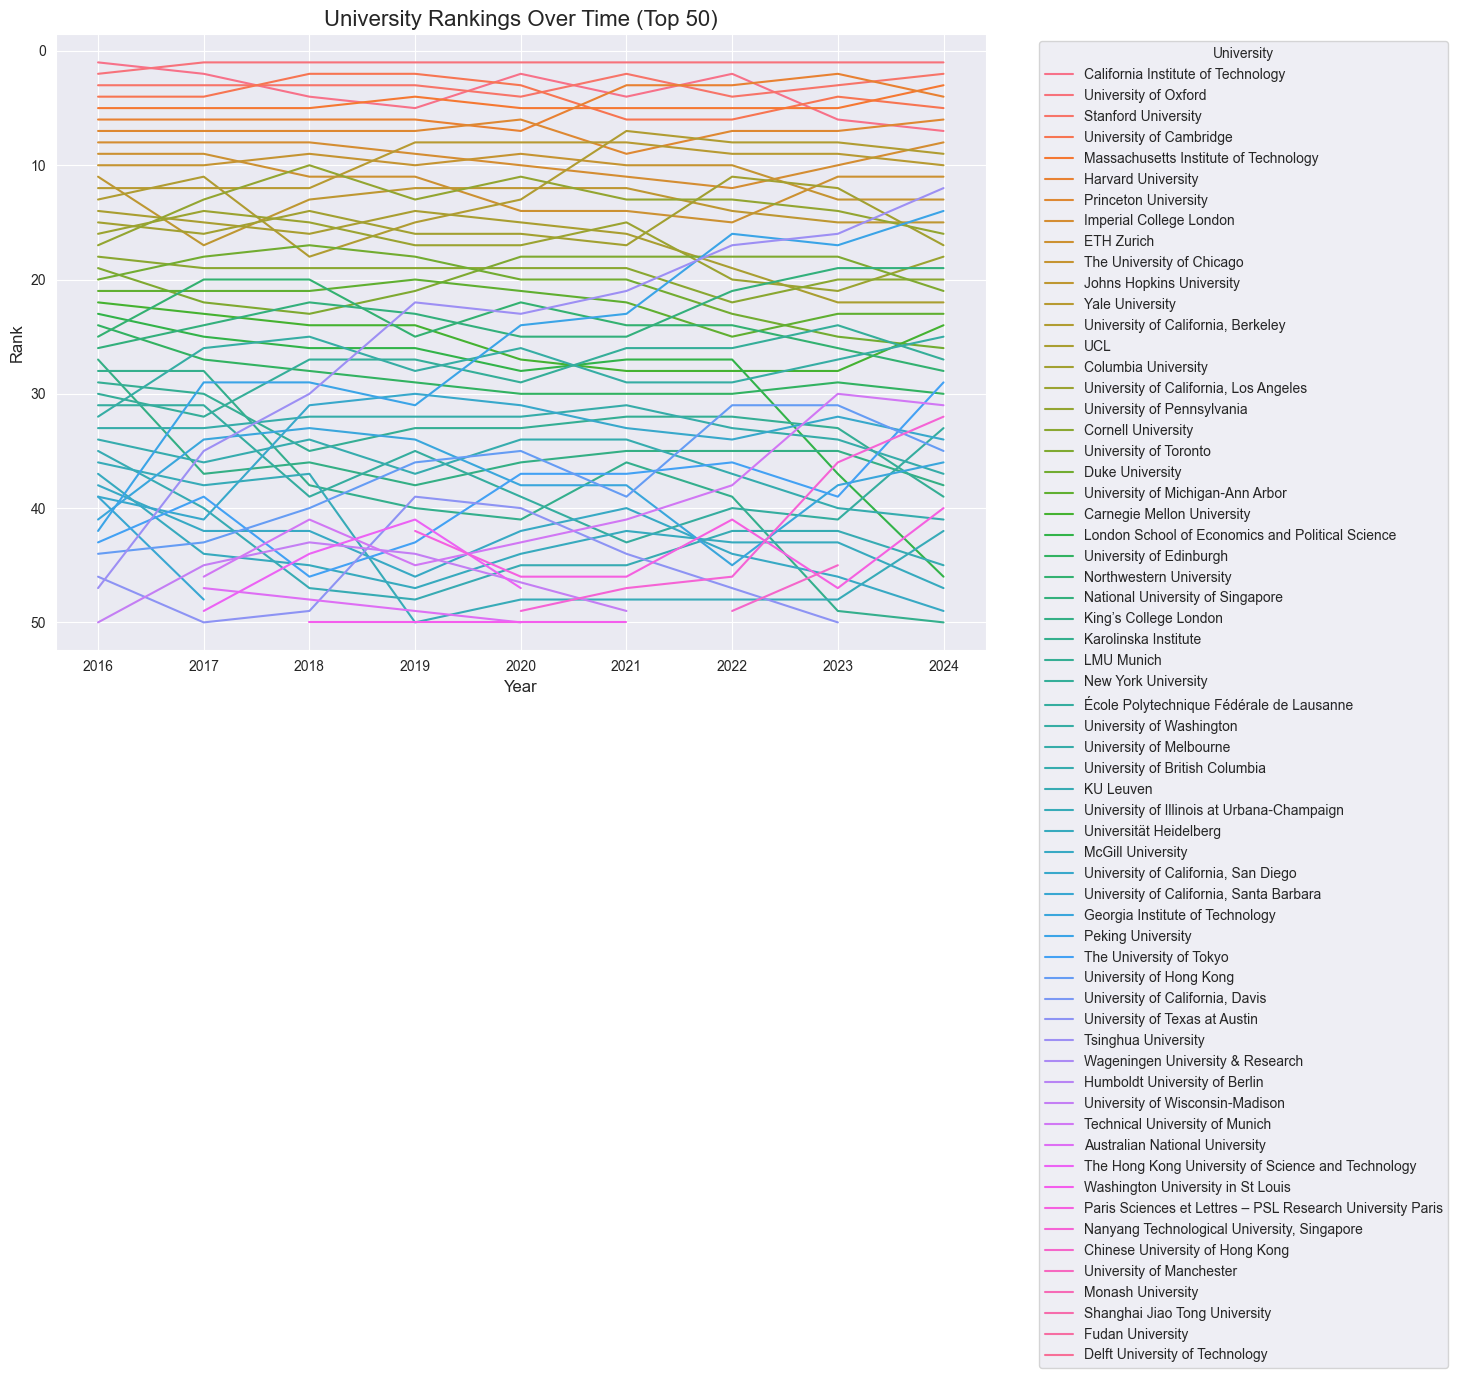

In [25]:
# displaying top 50 universities from 20
top50 = df.copy()
top50 = top50[top50['Rank'] <= 50]
top50 = top50[top50['Year'] != 2025]

plt.figure(figsize=(12, 8))
sns.lineplot(data=top50, x='Year', y='Rank', hue='Name', linewidth=1.5)
plt.gca().invert_yaxis()
plt.title("University Rankings Over Time (Top 50)", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Rank", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='University')
plt.show()

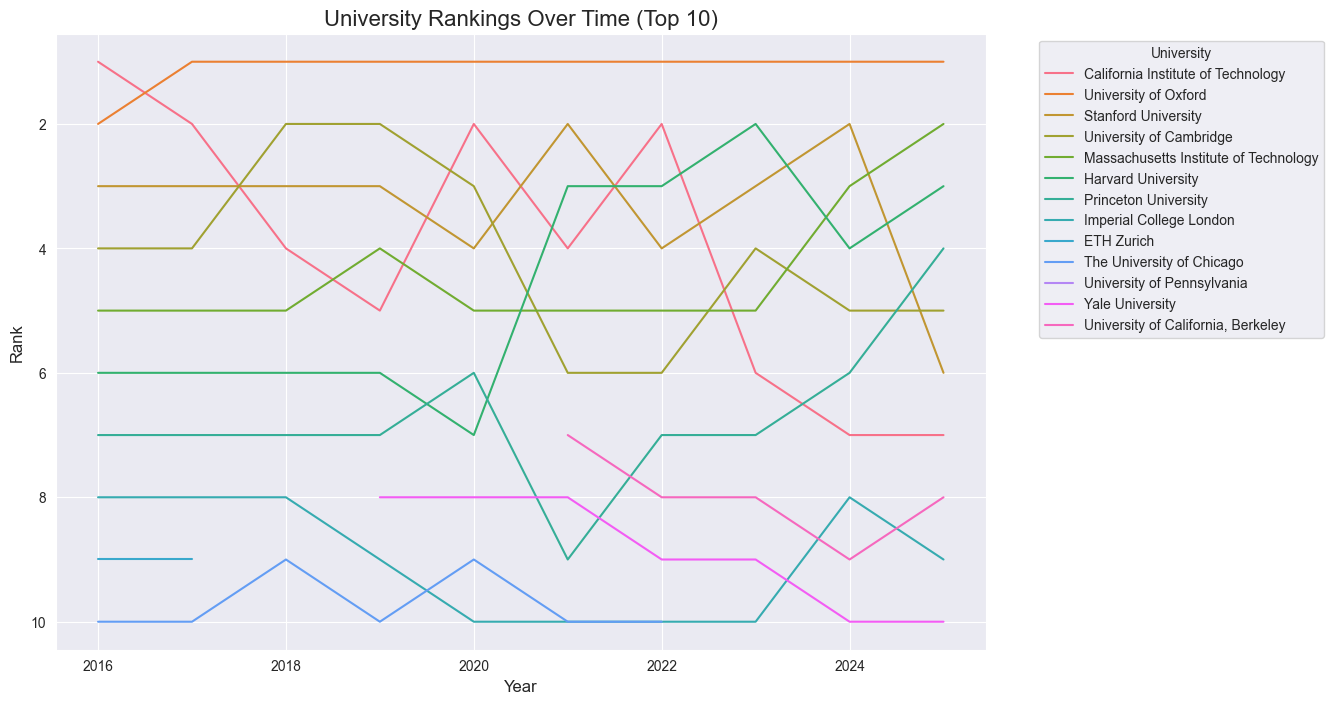

In [26]:
top10 = df.copy()
top10 = top10[top10['Rank'] <= 10]
plt.figure(figsize=(12, 8))
sns.lineplot(data=top10, x='Year', y='Rank', hue='Name', linewidth=1.5)
plt.gca().invert_yaxis()
plt.title("University Rankings Over Time (Top 10)", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Rank", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='University')
plt.show()

## Which country / continent / university stands out?

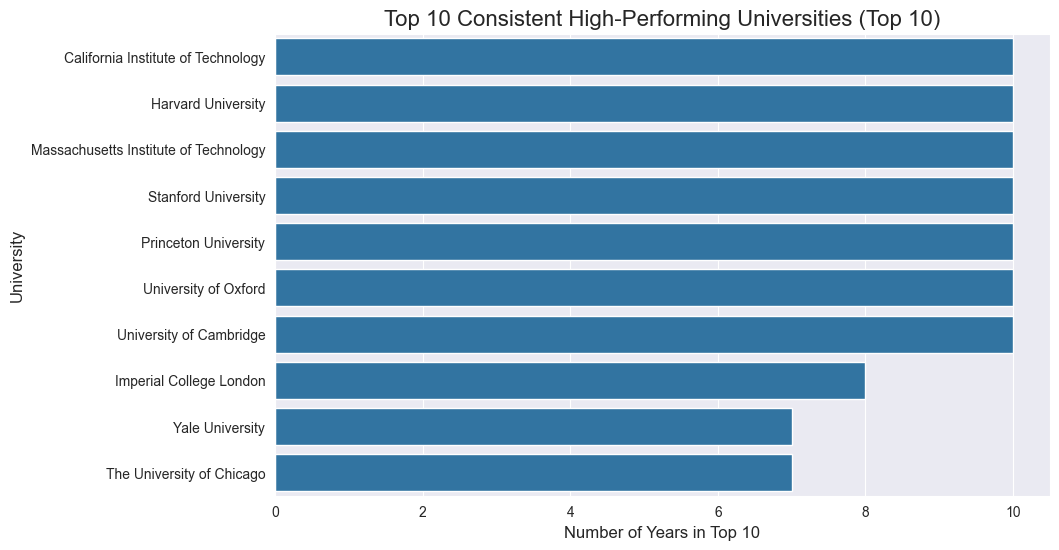

In [27]:
# highlight the universities that seem to perform really well consecutively
consistent_performers = (
    top10.groupby('Name')['Year']
    .count()
    .sort_values(ascending=False)
    .head(10)
)

plt.figure(figsize=(10, 6))
sns.barplot(x=consistent_performers.values, y=consistent_performers.index)
plt.title("Top 10 Consistent High-Performing Universities (Top 10)", fontsize=16)
plt.xlabel("Number of Years in Top 10", fontsize=12)
plt.ylabel("University", fontsize=12)
plt.show()


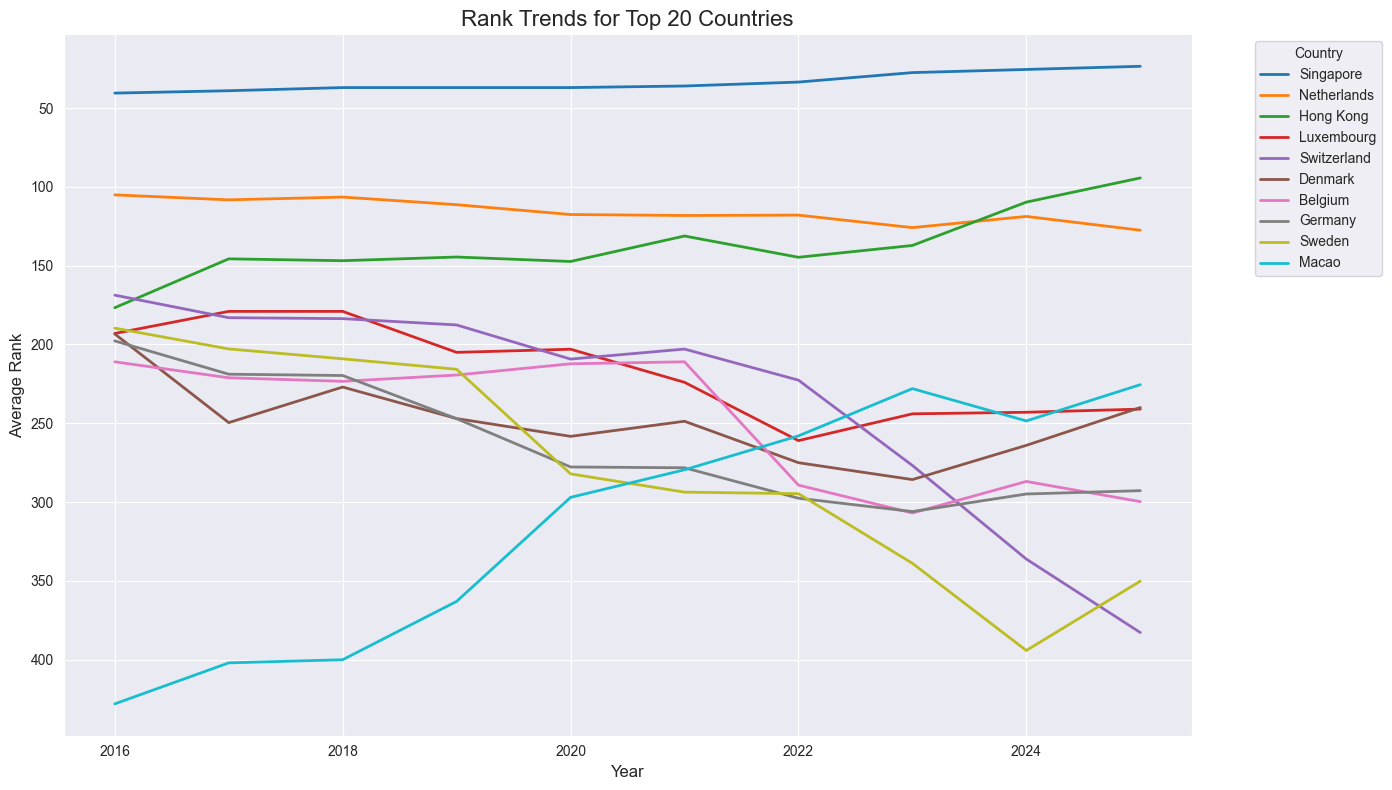

In [28]:

df_copy6 = df.copy()

df_copy6 = df_copy6.dropna(subset=['Rank', 'Year', 'Country'])

country_avg_rank_all_years = df_copy6.groupby('Country')['Rank'].mean().reset_index()

top_10_countries = country_avg_rank_all_years.sort_values('Rank').head(10)['Country']

df_copy6_top_10 = df_copy6[df_copy6['Country'].isin(top_10_countries)]

plt.figure(figsize=(14, 8))

for country in top_10_countries:
    country_data = df_copy6_top_10[df_copy6_top_10['Country'] == country]
    country_avg_rank = country_data.groupby('Year')['Rank'].mean().reset_index()

    sns.lineplot(
        data=country_avg_rank,
        x='Year',
        y='Rank',
        lw=2,
        label=country
    )

plt.title("Rank Trends for Top 20 Countries", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Average Rank", fontsize=12)
plt.gca().invert_yaxis()
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


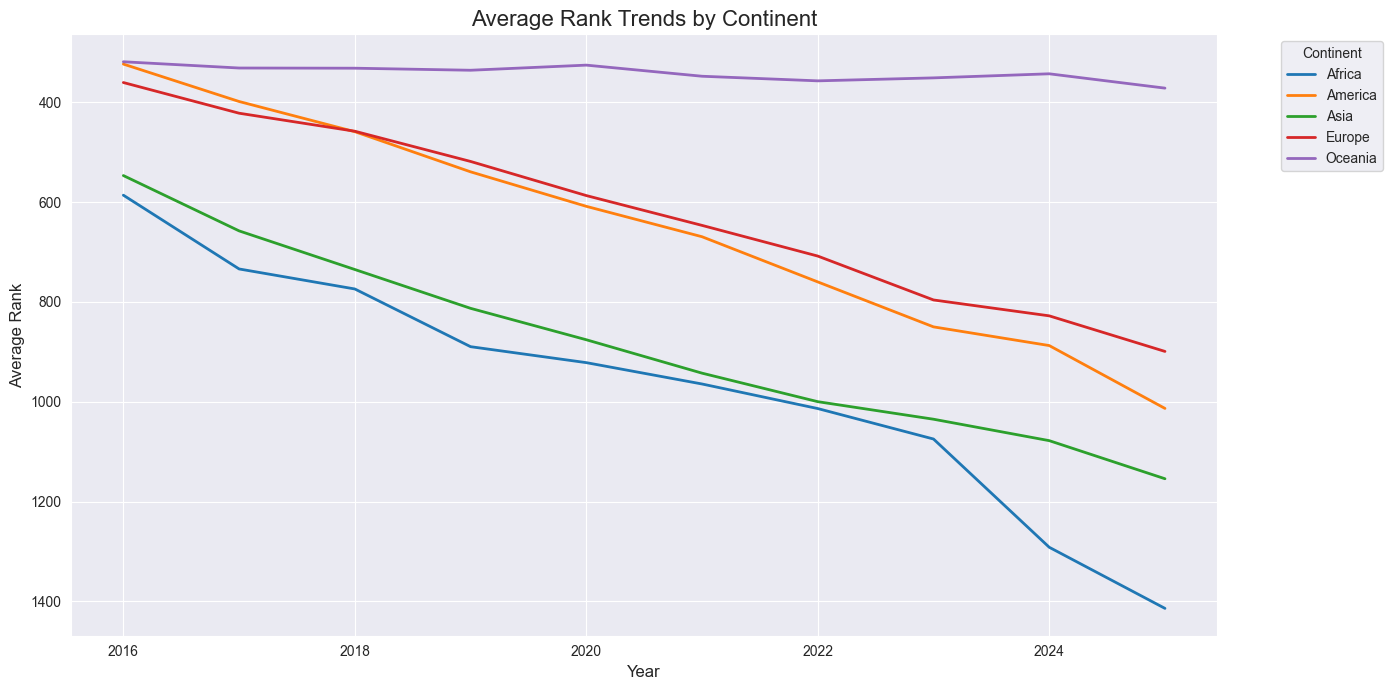

In [29]:

df_copy6 = df_copy6.dropna(subset=['Rank', 'Year', 'Continent'])
continent_avg_rank = df_copy6.groupby(['Year', 'Continent'])['Rank'].mean().reset_index()
plt.figure(figsize=(14, 7))
sns.lineplot(
    data=continent_avg_rank,
    x='Year',
    y='Rank',
    hue='Continent',
    lw=2
)
plt.title("Average Rank Trends by Continent", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Average Rank", fontsize=12)
plt.gca().invert_yaxis()
plt.legend(title='Continent', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### looking at the jumps or drops in ranking of universities from one year to the next:

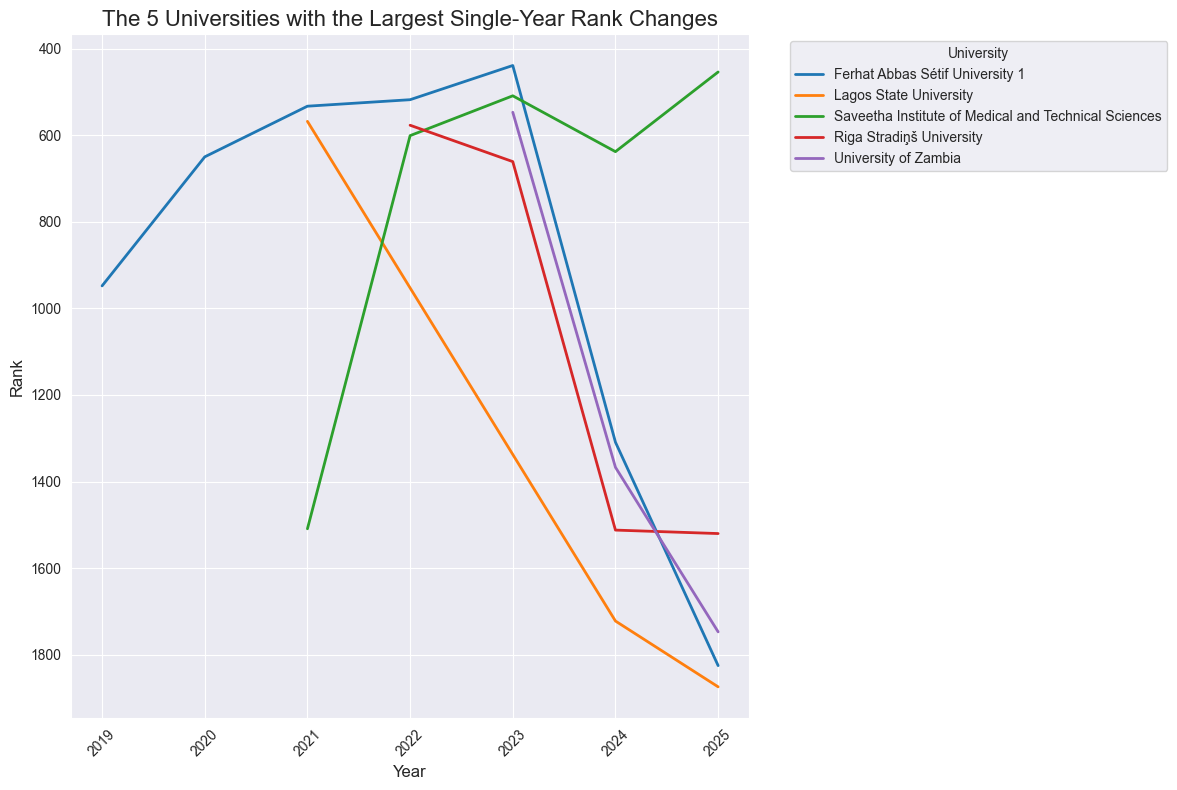

In [30]:
# Calculate year-over-year changes in rank

df_copy3 = df.copy()

df_copy3['Rank Change'] = df_copy3.groupby('Name')['Rank'].diff()

valid_groups = df_copy3.groupby('Name').filter(lambda group: group['Rank Change'].notna().any())

largest_jumps = valid_groups.loc[
    valid_groups.groupby('Name')['Rank Change'].apply(lambda x: x.dropna().abs().idxmax())
]

largest_jumps = largest_jumps.reset_index()
top_jumps = largest_jumps.loc[largest_jumps['Rank Change'].abs().nlargest(5).index]

plt.figure(figsize=(12, 8))
sns.lineplot(
    data=valid_groups[valid_groups['Name'].isin(top_jumps['Name'])],
    x='Year',
    y='Rank',
    hue='Name',
    markers=True,
    dashes=False,
    linewidth=2
)
plt.gca().invert_yaxis()
plt.title("The 5 Universities with the Largest Single-Year Rank Changes", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Rank", fontsize=12)
plt.legend(title='University', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


## Which fields dominate in each year?

In [31]:
df_copy = df.copy()
fields_of_study = ['Teaching', 'Research Environment', 'Research Quality', 'Industry Impact', 'International Outlook']

top_universities_by_field = {}
aggregated_df = df_copy.groupby('Name')[fields_of_study].mean().reset_index()

for field in fields_of_study:
    top_universities = (
        aggregated_df[['Name', field]]
        .sort_values(by=field, ascending=False)
        .head(3)
    )
    top_universities_by_field[field] = top_universities

for field, top_universities in top_universities_by_field.items():
    print(f"\nTop 3 Universities in {field} (Aggregated Over All Years):\n")
    print(top_universities)



Top 3 Universities in Teaching (Aggregated Over All Years):

                                       Name  Teaching
192      California Institute of Technology     93.68
1320                    Stanford University     93.58
825   Massachusetts Institute of Technology     91.95

Top 3 Universities in Research Environment (Aggregated Over All Years):

                         Name  Research Environment
1953     University of Oxford                 99.55
490        Harvard University                 98.92
1684  University of Cambridge                 98.73

Top 3 Universities in Research Quality (Aggregated Over All Years):

                                       Name  Research Quality
1320                    Stanford University             99.83
825   Massachusetts Institute of Technology             99.76
490                      Harvard University             99.45

Top 3 Universities in Industry Impact (Aggregated Over All Years):

                                                   Na

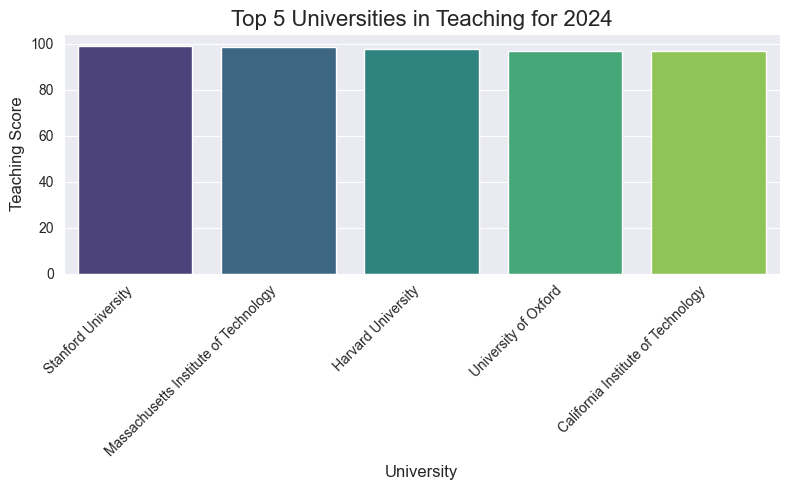

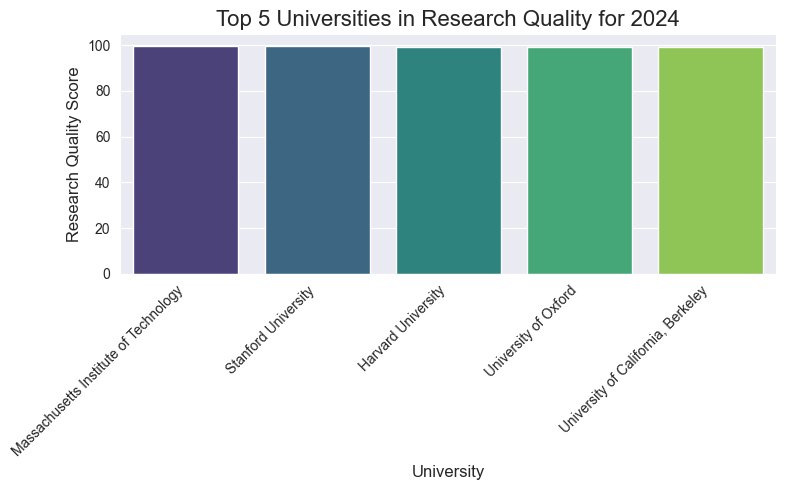

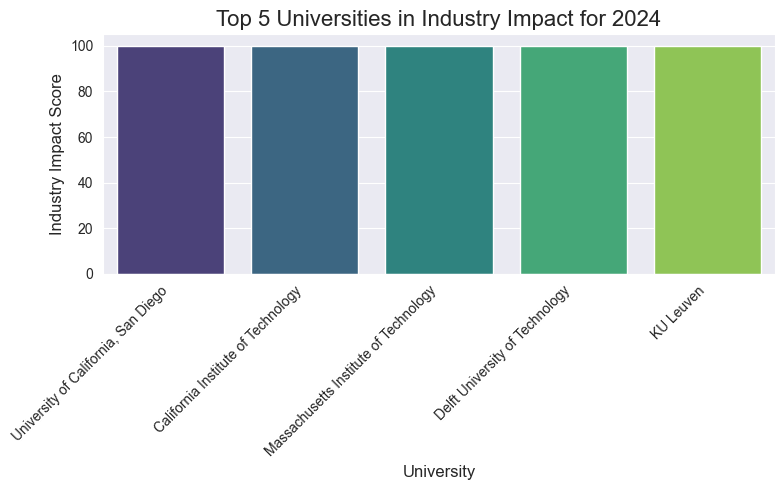

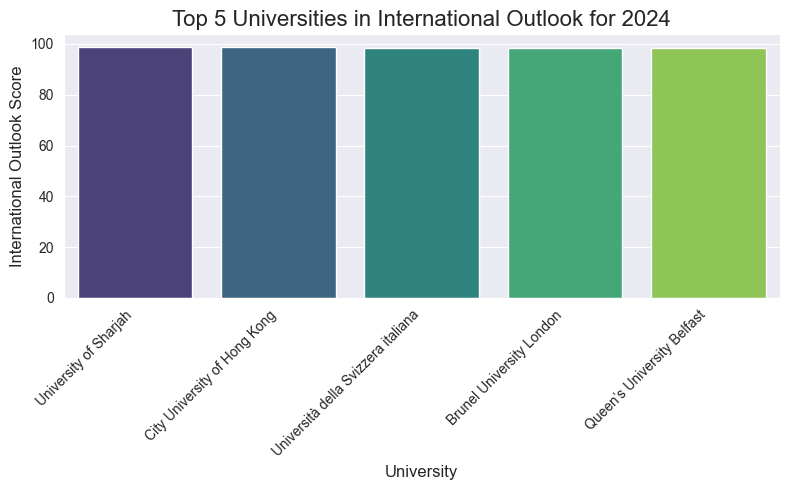

In [32]:
df_copy = df.copy()
fields_of_study = ['Teaching', 'Research Quality', 'Industry Impact', 'International Outlook']
df_2024 = df_copy[df_copy['Year'] == 2024]

top_universities_by_field_2024 = {}

for field in fields_of_study:
    top_universities = (
        df_2024[['Name', field]]
        .sort_values(by=field, ascending=False)
        .head(5)
    )
    top_universities_by_field_2024[field] = top_universities

for field, top_universities in top_universities_by_field_2024.items():
    plt.figure(figsize=(8, 5))
    sns.barplot(
        data=top_universities,
        y=field,
        x='Name',
        palette='viridis',
        hue='Name',
        legend=False
    )
    plt.title(f"Top 5 Universities in {field} for 2024", fontsize=16)
    plt.xlabel("University", fontsize=12)
    plt.ylabel(f"{field} Score", fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


# Load and prepare data

In [4]:
df = pd.read_csv("universities.csv")

df_train, df_test = train_test_split(df, test_size=0.2, random_state=random_state)

target_column = "Rank"
X = df_train.drop(columns=[target_column, "Overall Score", "Name", "Year", "Country"])
y = df_train[target_column]

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=random_state
)  

X_train.isna().sum()/X_train.shape[0]

X_test = df_test.drop(columns=[target_column, "Overall Score", "Name", "Year", "Country"])
y_test = df_test[target_column] 

## Encoding Continent column

In [6]:
enc = OneHotEncoder(drop="if_binary", sparse_output=False, handle_unknown="ignore")
encoded_X_train = enc.fit_transform(X_train[["Continent"]])
col_names = enc.get_feature_names_out(input_features=["Continent"])

encoded_X_train = pd.DataFrame(encoded_X_train, columns=col_names, index=X_train.index)
X_train = pd.concat([X_train.drop(columns=["Continent"]), encoded_X_train], axis=1)

encoded_X_valid = enc.transform(X_valid[["Continent"]])
encoded_X_valid = pd.DataFrame(encoded_X_valid, columns=col_names, index=X_valid.index)
X_valid = pd.concat([X_valid.drop(columns=["Continent"]), encoded_X_valid], axis=1)

encoded_X_test = enc.transform(X_test[["Continent"]])
encoded_X_test = pd.DataFrame(encoded_X_test, columns=col_names, index=X_test.index)
X_test = pd.concat([X_test.drop(columns=["Continent"]), encoded_X_test], axis=1)

## Handling missing values

In [8]:
print(X_train.isna().sum()/X_train.shape[0])

Student Population         0.000000
Students to Staff Ratio    0.000000
International Students     0.000000
Female to Male Ratio       0.049069
Teaching                   0.000000
Research Environment       0.000000
Research Quality           0.000000
Industry Impact            0.000000
International Outlook      0.000000
Population                 0.306898
CO2                        0.307113
Corruption                 0.373507
GDP                        0.460454
HDI                        0.441408
GII                        0.444205
Continent_Africa           0.000000
Continent_America          0.000000
Continent_Asia             0.000000
Continent_Europe           0.000000
Continent_Oceania          0.000000
dtype: float64


### Option 1: Imputing missing values

In [10]:
%%script false

imputer = SimpleImputer(strategy="mean")
X_train[["Female to Male Ratio", "Population", "CO2", "Corruption", "GDP", "HDI", "GII"]] = imputer.fit_transform(X_train[["Female to Male Ratio", "Population", "CO2", "Corruption", "GDP", "HDI", "GII"]])
X_valid[["Female to Male Ratio", "Population", "CO2", "Corruption", "GDP", "HDI", "GII"]] = imputer.transform(X_valid[["Female to Male Ratio", "Population", "CO2", "Corruption", "GDP", "HDI", "GII"]])
X_test[["Female to Male Ratio", "Population", "CO2", "Corruption", "GDP", "HDI", "GII"]] = imputer.transform(X_test[["Female to Male Ratio", "Population", "CO2", "Corruption", "GDP", "HDI", "GII"]])

print("Missing values left:")
print(X_train.isna().all().any())

Couldn't find program: 'false'


### Option 2: Removing sparse columns

In [12]:

imputer = SimpleImputer(strategy="mean")
X_train[["Female to Male Ratio"]] = imputer.fit_transform(X_train[["Female to Male Ratio"]])
X_valid[["Female to Male Ratio"]] = imputer.transform(X_valid[["Female to Male Ratio"]])
X_test[["Female to Male Ratio"]] = imputer.transform(X_test[["Female to Male Ratio"]])

def remove_sparse_cols(df, sparse_cols):
    df = df.drop(columns=sparse_cols)
    return df
    
X_train = remove_sparse_cols(X_train, ["Population", "CO2", "Corruption", "GDP", "HDI", "GII"])
X_valid = remove_sparse_cols(X_valid, ["Population", "CO2", "Corruption", "GDP", "HDI", "GII"])
X_test = remove_sparse_cols(X_test, ["Population", "CO2", "Corruption", "GDP", "HDI", "GII"])

print("Missing values left:")
print(X_train.isna().all().any())

Missing values left:
False


# Models & GridSearch

In [14]:
def grid_search(regressor, param_grid, X_train, y_train, X_valid, y_valid, cv: int = 5):
    scoring = {
        "R2": make_scorer(r2_score),
        "RMSE": make_scorer(root_mean_squared_error)
    }
    
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("regressor", regressor)
    ])
    
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring=scoring,
        refit="R2",
        cv=cv,
        verbose=1
    )
    
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    train_r2 = r2_score(y_train, best_model.predict(X_train))
    train_rmse = root_mean_squared_error(y_train, best_model.predict(X_train))
    valid_r2 = r2_score(y_valid, best_model.predict(X_valid))
    valid_rmse = root_mean_squared_error(y_valid, best_model.predict(X_valid))
    
    results = {
        "train_r2": train_r2,
        "train_rmse": train_rmse,
        "valid_r2": valid_r2,
        "valid_rmse": valid_rmse
    }
    
    return best_model, best_params, results


In [15]:
def evaluate_model(model, X_train, X_test, y_test, model_name):
    y_pred = model.predict(X_test)

    test_r2 = r2_score(y_test, y_pred)
    test_rmse = root_mean_squared_error(y_test, y_pred)
    
    residuals = y_test - y_pred
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.scatter(y_pred, residuals, alpha=0.6)
    plt.axhline(0, color="red", linestyle="--", linewidth=1)
    plt.title("Residual Plot")
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.scatter(y_test, y_pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=2)
    plt.title("Parity Plot")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.grid()

    plt.tight_layout()
    plt.savefig(f"results/{model_name}_eval")
    plt.close("all")
    
    return test_r2, test_rmse

In [16]:
def show_coefs_and_eval_pipeline(best_model_pipeline, X_train, X_test, y_test, model_name):
    model = best_model_pipeline.named_steps["regressor"]
    coefficients = model.coef_
    feature_importance = pd.DataFrame({
        "Feature": X_train.columns,
        "Coefficient": coefficients
    })
    
    feature_importance["Abs_Coefficient"] = feature_importance["Coefficient"].abs()
    feature_importance = feature_importance.sort_values(by="Abs_Coefficient", ascending=False)
        
    top_features = feature_importance.head(10)
    
    plt.figure(figsize=(10, 6))
    plt.barh(top_features["Feature"], top_features["Coefficient"], color="skyblue")
    plt.xlabel("Coefficient Value")
    plt.ylabel("Feature")
    plt.title(f"Top 10 Features Contributing to {model_name} Regression")
    plt.gca().invert_yaxis()
    plt.savefig(f"results/{model_name}_coefs")
    plt.close("all")

    return evaluate_model(model, X_train, X_test, y_test, model_name)

## Lasso

In [18]:
def train_lasso(X_train, y_train, X_valid, y_valid):
    lasso_params = {
        "regressor__alpha": [0.1, 1, 10],
        "regressor__max_iter": [1000, 5000]
    }
    lasso = Lasso(random_state=42)

    return grid_search(
        regressor=lasso,
        param_grid=lasso_params,
        X_train=X_train,
        y_train=y_train,
        X_valid=X_valid,
        y_valid=y_valid
    )

## Ridge

In [20]:
def train_ridge(X_train, y_train, X_valid, y_valid):
    ridge_params = {
        "regressor__alpha": [0.1, 1, 10, 100],
        "regressor__max_iter": [1000, 5000]
    }
    ridge = Ridge(random_state=random_state)
    
    return grid_search(
        regressor=ridge,
        param_grid=ridge_params,
        X_train=X_train,
        y_train=y_train,
        X_valid=X_valid,
        y_valid=y_valid
    )

## GradientBoostingRegressor

In [22]:
def train_gbr(X_train, y_train, X_valid, y_valid):
    gbr_params = {
        "regressor__n_estimators": [50, 100, 200],
        "regressor__learning_rate": [0.01, 0.1, 0.2],
        "regressor__max_depth": [3, 5, 7]
    }
    gbr = GradientBoostingRegressor(random_state=random_state)
    
    return grid_search(
        regressor=gbr,
        param_grid=gbr_params,
        X_train=X_train,
        y_train=y_train,
        X_valid=X_valid,
        y_valid=y_valid
    )

# Experiments

In [24]:
results_df = pd.DataFrame(columns=["Model", "Dataset", "R2", "RMSE"])

In [25]:
original_feature_cols = ["Student Population", "Students to Staff Ratio",
       "International Students", "Female to Male Ratio", "Teaching",
       "Research Environment", "Research Quality", "Industry Impact",
       "International Outlook"]

In [26]:
X_train_original = X_train[original_feature_cols]
X_valid_original = X_valid[original_feature_cols]
X_test_original = X_test[original_feature_cols]

In [27]:
X_train_other = X_train.drop(columns=original_feature_cols)
X_valid_other = X_valid.drop(columns=original_feature_cols)
X_test_other = X_test.drop(columns=original_feature_cols)

In [28]:
datasets = {
    "combined": [X_train, y_train, X_valid, y_valid, X_test, y_test],
    "original": [X_train_original, y_train, X_valid_original, y_valid, X_test_original, y_test],
    "other": [X_train_other, y_train, X_valid_other, y_valid, X_test_other, y_test]
}

models = [
    ("lasso", train_lasso, show_coefs_and_eval_pipeline),
    ("ridge", train_ridge, show_coefs_and_eval_pipeline),
    ("GradientBoostingRegressor", train_gbr, evaluate_model)
]

In [29]:
for dataset_name, data in datasets.items():
        X_train, y_train, X_valid, y_valid, X_test, y_test = data

        for model_name, train_function, eval_function in models:
            best_model, best_params, results = train_function(X_train, y_train, X_valid, y_valid)
            test_r2, test_rmse = eval_function(best_model, X_train, X_test, y_test, f"{model_name}_{dataset_name}")
            new_row ={"Model": model_name, "Dataset": dataset_name, "R2": test_r2, "RMSE": test_rmse}
            results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)


Fitting 5 folds for each of 6 candidates, totalling 30 fits


C:\Users\kilia\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but Lasso was fitted without feature names
  warnings.warn(
C:\Users\kilia\AppData\Local\Temp\ipykernel_54900\2994951940.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)


Fitting 5 folds for each of 8 candidates, totalling 40 fits


C:\Users\kilia\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits


C:\Users\kilia\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but Lasso was fitted without feature names
  warnings.warn(


Fitting 5 folds for each of 8 candidates, totalling 40 fits


C:\Users\kilia\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits


C:\Users\kilia\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but Lasso was fitted without feature names
  warnings.warn(


Fitting 5 folds for each of 8 candidates, totalling 40 fits


C:\Users\kilia\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


Fitting 5 folds for each of 27 candidates, totalling 135 fits


In [30]:
results_df.to_csv("results/scores.csv", index=False)

In [31]:
best_model_lasso, best_params_lasso, results_lasso = train_lasso(X_train, y_train, X_valid, y_valid)
new_row = sshow_coefs_and_eval_pipeline(best_model_lasso, X_train, X_test, y_test, "lasso_combined")
results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


NameError: name 'sshow_coefs_and_eval_pipeline' is not defined

In [ ]:
best_model_ridge, best_params_ridge, results_ridge = train_ridge(X_train, y_train, X_valid, y_valid)
new_row = sshow_coefs_and_eval_pipeline(best_model_ridge, X_train, X_test, y_test, "ridge_combined")
results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)

In [ ]:
best_model_gbr, best_params_gbr, results_gbr = train_gbr(X_train, y_train, X_valid, y_valid)
new_row = sevaluate_model(best_model_gbr, X_test, y_test, "GradientBoostingRegressor_combined")
results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)